In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time



In [21]:
# download the data here:
#http://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/029p1/catalog.html?dataset=CDIP_Archive/029p1/029p1_historic.nc

In [11]:
g = 9.81 # m2/sec acceleration due to gravity

In [18]:
stn = '029' # the cdip station
file_cdip = ('/Users/gwen29360/Desktop/POSTDOC/Mines/S_MODE/DATA/CDIP/%sp1_historic.nc'%stn)

ds = xr.open_dataset(file_cdip) # load data
date_saildrone_obs = np.datetime64('2010-10-25T22:30') # studied date
ds = ds.sel(waveTime = date_saildrone_obs, method = 'nearest')
creator_name = 'g.marechal'

In [13]:
ds_spec = buoy_spectrum2d(ds.waveEnergyDensity.values,\
                          ds.waveA1Value.values, \
                          ds.waveA2Value.values,\
                          ds.waveB1Value.values,\
                          ds.waveB2Value.values,
                          ds.waveFrequency.values,\
                          dirs = np.arange(0,365,10))
hs, tp, dp, sigma_th = compute_wave_parameter(ds_spec)


/Users/gwen29360/opt/anaconda3/envs/smode_env/lib/python3.7/site-packages/ipykernel_launcher.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


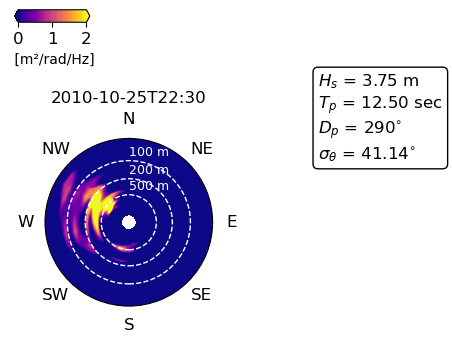

In [14]:
plot_directional_wave_spectrum(ds_spec, vmin = 0, vmax = 2)

In [10]:


def period_from_wavelength(WL):
    """
    purpose: estimate the period from the wave wavelength using the linear disp. rel in deep water
    --------
    input:
    -------
    WL: the wave wavelength
    output:
    -------
    the dominant period
    """ 
    T = np.sqrt(2*np.pi*WL/9.81) #wind waves in deep water : dispersion relation

    return T

def wavelength_from_period(period):
    """
    purpose: estimate the wavelength from the wave period using the linear disp. rel in deep water
    --------
    input:
    -------
    period: the dominant period in sec
    output:
    -------
    the dominant wavelength in meter
    """
        
    g = 9.81 # acceleration due to gravity
    freq = 1/period # wave frequency
    sigma = 2*np.pi*freq # wave pulsation
    k = sigma**2/g # wavenumber
    lambda_p = 2*np.pi/k #wind waves in deep water : dispersion relation
    return lambda_p

#2D wave spectrum

def buoy_spectrum2d(sf,a1,a2,b1,b2, frequency, dirs = np.arange(0,365,10)):
    """(a1,a2,b1,b2,en,ndirs):
    purpose: compute spectrum(f,theta) from coef ai,bi
    ---------
    # Maximum entropy method to estimate the Directional Distribution
    
    # Maximum Entropy Method - Lygre & Krogstad (1986 - JPO)
    # Eqn. 13:
    # phi1 = (c1 - c2c1*)/(1 - abs(c1)^2)
    # phi2 = c2 - c1phi1
    # 2piD = (1 - phi1c1* - phi2c2*)/abs(1 - phi1exp(-itheta) -phi2exp(2itheta))^2
    # c1 and c2 are the complex fourier coefficients
    
    # inputs :the omnidirectional wave spectrum + the first 4 in dirs in degrees
    ----------
    #outputs: The DataArray with the directional wave spectrum
    ----------
    """
    nfreq = np.size(sf)
    nbin = np.size(dirs)
    
    c1 = a1+1j*b1
    c2 = a2+1j*b2
    p1 = (c1-c2*np.conj(c1))/(1.-abs(c1)**2)
    p2 = c2-c1*p1
    
    # numerator(2D) : x
    x = 1.-p1*np.conj(c1)-p2*np.conj(c2)
    x = np.tile(np.real(x),(nbin,1)).T
    
    # denominator(2D): y
    a = dirs*np.pi/180.
    e1 = np.tile(np.cos(a)-1j*np.sin(a),(nfreq,1))
    e2 = np.tile(np.cos(2*a)-1j*np.sin(2*a),(nfreq,1))
    
    p1e1 = np.tile(p1,(nbin,1)).T*e1
    p2e2 = np.tile(p2,(nbin,1)).T*e2
    
    y = abs(1-p1e1-p2e2)**2
    
    D = x/(y*2*np.pi)
    
    # normalizes the spreading function,
    # so that int D(theta,f) dtheta = 1 for each f  
    dth = dirs[1]-dirs[0]

    tot = np.tile(np.sum(D, axis=1)*dth/180.*np.pi,(nbin,1)).T
    D = D/tot
    
    sp2d = np.tile(sf,(nbin,1)).T*D
    frequency = frequency
    direction = dirs * np.pi/180
    wave_spectrum = xr.DataArray(sp2d, [('frequency', frequency), ('direction', direction)])
    ds_out = xr.Dataset({
                        'frequency': ('frequency', frequency),
                        'direction': ('direction', direction),
                        })

    ds_out['wave_spectrum'] = wave_spectrum

    ds_out.wave_spectrum.attrs['units'] = 'm^2/Hz/rad'
    ds_out.wave_spectrum.attrs['long_name'] = 'The directional-frequency wave spectrum'
    ds_out.frequency.attrs['units'] = 'Hz'
    ds_out.wave_spectrum.attrs['long_name'] = 'wave frequency'
    ds_out.direction.attrs['units'] = 'rad'
    ds_out.direction.attrs['units'] = 'wave direction'
    ds_out.attrs['creator_name'] = creator_name
    ds_out.attrs['time_creation'] = time.ctime()
    ds_out.attrs['date_wave_obs'] = date_saildrone_obs

    return ds_out


def compute_wave_parameter(ds):
    """
    purpose: Compute the significant wave height, the dominant wave period and direction, and the directional spreading of the dominant waves
    --------
    input:
    -------
    ds: the dataArray that contains the directional wave spectrum (from buoy_spectrum2d.py)
    output:
    -------
    The significant wave height, the dominant wave period and direction, and the directional spreading of the dominant waves
    """
    #########
    # --- the frequency and direction steps
    #########
    dth = np.diff(ds.direction.values)[0]
    df = np.gradient(ds.frequency.values)

    etot = np.nansum(np.nansum(ds.wave_spectrum.T*df, axis= 1), axis = 0) * dth # the total wave variance density
    hs  = 4*np.sqrt(etot) # the significant wave height
    #########
    # --- the indices where the peak of energy is
    #########
    idf = np.where(ds.wave_spectrum==np.amax(ds.wave_spectrum))[0][0]
    idth= np.where(ds.wave_spectrum==np.amax(ds.wave_spectrum))[1][0]
    #########
    # --- the dominant direction and period
    #########    
    dp = ds.direction.isel(direction = idth).values * 180/np.pi
    tp = 1/ds.frequency.isel(frequency = idf).values

    the_m = np.nansum(ds.wave_spectrum*ds.direction.values, axis = 1)/(np.nansum(ds.wave_spectrum, axis = 1)) # the mean wave direction for all frequencies
    #########
    # --- The directional spreading
    #########  
    sig = []          
    for k in range(len(ds.frequency)):                                  
        sig.append((np.nansum(ds.wave_spectrum[k, :].T * (ds.direction.values - the_m[k])**(2), axis = 0)/(np.nansum(ds.wave_spectrum[k, :], axis = 0)))**(1/2)) 
    sigma_th = sig[idf]* 180/np.pi
    
    return hs, tp, dp, sigma_th

def plot_directional_wave_spectrum(ds, vmin = 0, vmax = 10):
    
    """
    purpose: Plot the directional wave spectrum in a polar frame
    --------
    input:
    -------
    ds: the dataArray that contains the directional wave spectrum (from buoy_spectrum2d.py)
    vmin: the min value of the spectrum
    vmax: the max value of the spectrum

    output:
    -------
    The plot of the directional wave spectrum
    """
    props = dict(boxstyle='round', facecolor='w', alpha=1)


    dir_1d = ds.direction.values
    freq_1d = ds.frequency.values
    DIR0, FREQ0 = np.meshgrid(dir_1d, freq_1d)
    fig,ax=plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (2.5, 2.5))
    #
    p1=plt.contourf(DIR0, FREQ0, np.log(ds.wave_spectrum.values), np.linspace(vmin, vmax, 30), extend = 'both', cmap = 'plasma') # the directional wave spec
    plt.ylim([0,0.3])
    ax.set_rmax(.20)
    ax.set_theta_offset(np.pi/2) # shift the 0 to the nroth
    ax.set_theta_direction(-1) # swap the direction (clockwise)
    plt.tight_layout()
    angle_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']
    ax.set_rlabel_position(180 + 45)
    #ax.set_ylim(0, 30)#set_rmax(30)
    #ax.set_ylabels('Wave period [s]', labelpad = 20)
    ax.set_thetagrids(angles = range(0, 360, 45),
                          labels = angle_labels,fontsize=12)
    ax.set_ylim([.01, .18])

    #############,
    #---White circles
    #############
    radius_050m=np.sqrt(g*2*np.pi/(50.*4*np.pi**2))
    radius_100m=np.sqrt(g*2*np.pi/(100.*4*np.pi**2))
    radius_200m=np.sqrt(g*2*np.pi/(200.*4*np.pi**2))
    radius_500m=np.sqrt(g*2*np.pi/(500.*4*np.pi**2))
    #radius_300m=(2*np.pi)/300.


    #circle1 = plt.Circle((0.0, 0.0), radius_050m, color='white',transform=ax.transData._b,linestyle='--',fill=False)
    #ax.add_patch(circle1)
    circle2 = plt.Circle((0.0, 0.0), radius_100m, color='white',transform=ax.transData._b,linestyle='--',fill=False)
    ax.add_patch(circle2)
    circle3 = plt.Circle((0.0, 0.0), radius_200m, color='w',transform=ax.transData._b,linestyle='--',fill=False)
    ax.add_patch(circle3)
    circle4 = plt.Circle((0.0, 0.0), radius_500m, color='w',transform=ax.transData._b,linestyle='--',fill=False)
    ax.add_patch(circle4)
    #plt.text(0,radius_050m,'50 m',color='w')
    plt.text(0, radius_100m+.02,'100 m',color='w', fontsize = 9)
    plt.text(0, radius_200m+.02,'200 m',color='w', fontsize = 9)
    plt.text(0, radius_500m+.02,'500 m',color='w', fontsize = 9)

    ax.set_yticklabels([])


    ax.grid(False)


    cbar_ax = fig.add_axes([0.05, 1.3, .3, 0.05])
    cbar=fig.colorbar(p1, cax=cbar_ax, shrink=0.5,aspect=155,extend='max',orientation='horizontal', ticks = [vmin, (vmin+vmax)/2, vmax])
    cbar.ax.tick_params(labelsize=12) 
    cbar.ax.set_xlabel(' [m²/rad/Hz]',rotation=0)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    hs, tp, dp, sigma_th = compute_wave_parameter(ds_spec)
    ax.text(.9, .5, '$H_s$ = %.2f m\n$T_p$ = %.2f sec\n$D_p$ = %i$^{\circ}$\n$\\sigma_{\\theta}$ = %.2f$^{\circ}$'%(hs, tp, dp, sigma_th),  fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_title('%s'%str(ds_spec.attrs['date_wave_obs']))



In [ ]:
#